# STAT5243 Project 4: Causal Inference

***Group 2:***

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

## Introduction

In this project, we are going to use two different ways to esitimate propensity scores and three algorithms to estimate ATE. 

Propensity Scores: (boosting Stumps)
1. GBM 
2. XGboost

Algorithms:
1. Stratification
2. Regression Adjustment
3. Stratification + Regression Adjustment 

Beyond that we also tried to resample the data to deal with the inbalance issue in our dataset by using oversampling and smote.

#### Basic workflow notebook.  

This notebook is intended for ONE dataset (specified in section 1)

trained to several models (specified in section 2)

producing several options for propensity score (defined in section 3). 

Please use this workbook as template to test one certain combination only, and compile the result in a new notebook. 

###### Propensity Score Estimation

We define the propensity score as:

$$e(x) = Pr(T =1|X=x)$$

We assume that: 

$$0<e(x)<1$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(42)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

## 0. Context

The prototype datasets are

In [2]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [3]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

## 1. Import and explore data

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

In [4]:
##############################################################################
##############################################################################
# UPDATE THE DATA USED FOR THE WHOLE NOTEBOOK HERE
# Development choices include highDim_dataset and lowDim_dataset
#

dataset = lowDim_dataset.copy()
dataset_name = "Low Dimensional Dataset"
true_ATE = low_true_ATE


# To use the low dim, import it instead 
# dataset = pd.read_csv('../data/lowDim_dataset.csv')

#
#
#
##############################################################################
##############################################################################

In [5]:
print(dataset.shape)
dataset.head()

(500, 24)


,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


Other data used by this workbook must be structured as above. The first column `Y` is the experimental result, second column `A` is the control/treatment label (often referred to as `z` in the literature), and the rest are associated variables, which we label collectively as `X`. For `X` the column naming is unimportant. 

It is convenient to extract only the X portion

In [6]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [7]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,0.00,0.00,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,0.42,0.05,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [8]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title("Data Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

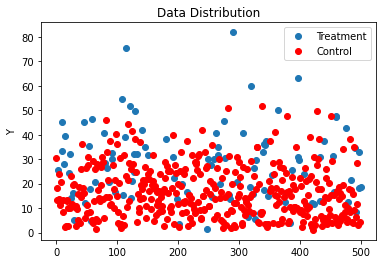

In [9]:
plotComposition(dataset)

### Naive estimate of ATE

In [10]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [11]:
naive_ATE(dataset)

10.602068661915688

### Are the data sets balanced?

In [12]:
def checkComposition(dataset):
    print("The dataset contains:\nTreatment:", 
          len(dataset[dataset.A == 1]), "cases"
          "\nControl:", 
          len(dataset[dataset.A == 0]), "cases")

In [13]:
checkComposition(dataset)

The dataset contains:
Treatment: 106 cases
Control: 394 cases


Thus in this case, the data is slightly imbalanced, but acceptable. In any cases, one can use oversampling or smote to balance the data. Note that this may not be beneficial for some ATE estimation algorithm. 

###### Oversampling to deal with the imbalance data

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. We use oversampling to do the resampling instead of undersampling. Since undersampling removes instances from data that may be carrying some important information.


1. Oversample: 

To replication the small sample to match the number to the larger sample size.

2. SMOTE: Synthetic Minority Oversampling Technique

SMOTE enables the synthetic samples generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.



In [14]:
def Oversample(dataset):
    """ 
    Perform basic oversampling on structured data
    
    Updated: inplace
    """
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x, y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    
    dataset_oversampled = x
    dataset_oversampled.insert(1, 'A', y)
    
    return dataset_oversampled

The dataset contains:
Treatment: 394 cases
Control: 394 cases


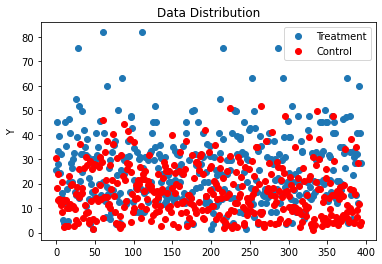

In [15]:
dataset_oversampled = Oversample(dataset)

checkComposition(dataset_oversampled)
plotComposition(dataset_oversampled, reset_index=True)

In [16]:
dataset_oversampled.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [17]:
def SMOTE(dataset):
    """ 
    Perform basic SMOTE sampling on structured data
    
    Updated: inplace
    """    
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    
    dataset_smote = x
    dataset_smote.insert(1, 'A', y)
    
    return dataset_smote

The dataset contains:
Treatment: 384 cases
Control: 384 cases


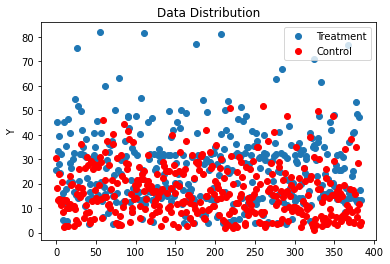

In [18]:
dataset_smote = SMOTE(dataset)

checkComposition(dataset_smote)
plotComposition(dataset_smote, reset_index=True)

In summary, there are three dataset that can be used: orginial, oversampled, and SMOTE. For testing purpose, change the variable splitted in the beginning of the next section, instead of pasting them all into one notebook. 

## 2. Calculating the propensity score

The propensity score is estimated by applying machine learning methods on the `X` variable to fit the label `A`. For this purpose (and this purpose only, NOT for the ATE score for instance), the dataset is splitted into train and test set. 

### Split into train and test set

In [19]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

Update dataset name HERE to test the original, oversampled, SMOTE, or any new dataset. 

In [20]:
##############################################################################
##############################################################################
# UPDATE DATA SET USED IN SECTION 2 HERE
# Development choices include dataset, dataset_oversampled and dataset_smote
#

X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(dataset)

#
#
#
##############################################################################
##############################################################################

### Propensity Score - Boosted Stumps

In this notebook we use GBM and XGboost. For any choices of learner, it is desirable to perform cross validation and grid search for the best model. We then evaluate the model prediction on the test set. 

#### Gradient Boosting

In [21]:
param_grid = {
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 4],
              'n_estimators': [5, 10, 15, 20],
              'min_samples_leaf':[1, 3, 5]
              }

In [22]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [23]:
# grid_search(
#     X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), 
#     param_grid=param_grid,
#     print_step=True
# )

A copy of best hyperparameters from grid search

In [24]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_samples_split': 4, 'n_estimators': 20}

In [25]:
gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train)

In [26]:
print(gbm.score(X_train, A_train))
print(gbm.score(X_test, A_test))

0.8975
0.81


In [27]:
propensity_score_gbm = np.exp(gbm.predict_log_proba(dataset.iloc[:, 2:]))[:, 1]

#### Weighted XGBoost

In [28]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[5, 10, 15, 20],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [29]:
# grid_search(X_train, A_train, 
#             model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE),
#             param_grid = param_grid_xgb, 
#             print_step=True, 
#             cv=5
#            )           

A copy of best hyperparameters from grid search

In [30]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [31]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.875
0.83


In [32]:
propensity_score_xgb = xgb.predict_proba(np.array(dataset.iloc[:, 2:]))[:, 1]

To summarize section 2, we have obtained the propensity score using GBM and XGBoost. These can now be used to calculate the ATE score. 

## 3. Calculating ATE

To calculate the ATE score, the orignal data (without any methods of train/test splitting, weighting or oversampling) is used. 

### Extract relevant data for ATE calculation

It is convenient to attach the newly constructed propensity score with `A` and `Y`. For the stratification, this is all required. However for regression method, `X` is also required to remove further confounding factors. 

In [33]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

In [34]:
##############################################################################
# UPDATE PROPENSITY SCORE OPTION HERE
#
#

data_for_ATE = combine_data(propensity_score_xgb, dataset.A, dataset.Y)

#
#
#
##############################################################################
##############################################################################

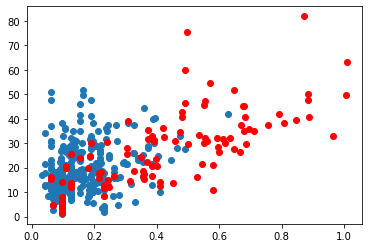

In [35]:
plt.plot(data_for_ATE[data_for_ATE.A==0].e, 
         data_for_ATE[data_for_ATE.A==0].Y, 'o')
plt.plot(data_for_ATE[data_for_ATE.A==1].e, 
         data_for_ATE[data_for_ATE.A==1].Y, 'ro')
plt.show()

### ATE Estimate - Stratification

In [36]:
def Stratify(data_for_ATE:pd.DataFrame, k:int):
    
    data_copy = data_for_ATE.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [37]:
Stratify(data_for_ATE, 5).head()

,e,A,Y,bin
0,0.061738,0.0,30.486999,0
1,0.262498,0.0,18.208417,3
2,0.096416,0.0,13.485040,0
3,0.304963,1.0,25.699678,3
4,0.339288,0.0,23.752968,4


In [38]:
def Calculate_ATE_Strat(data_for_ATE:pd.DataFrame, k:int):
    
    n = data_for_ATE.shape[0]
    
    data_copy = Stratify(data_for_ATE, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        ATE += (nj/n) * ( np.average(Qj[Qj.A==1].Y) - np.average(Qj[Qj.A==0].Y) )
    
    return ATE

In [39]:
Calculate_ATE_Strat(data_for_ATE, 5)

-0.6551469608144478

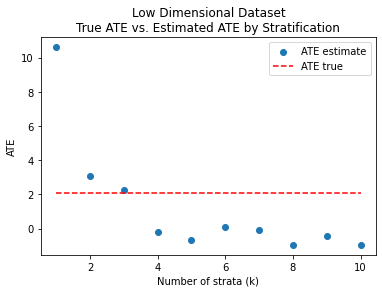

In [40]:
plt.scatter(range(1,11), [Calculate_ATE_Strat(data_for_ATE, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title(dataset_name + "\nTrue ATE vs. Estimated ATE by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

In [ ]:
def Calculate_ATE_Strat_CV(data_for_ATE:pd.DataFrame, k:int):
    return None

### ATE Estimate - Regression and Stratification with Regression Adjustment

With regression adjustment, data for each bin is further corrected using regression on X, with level variable `A`. 

Note that setting k = 1 bin is equivalent to performing only regression estimation. 


In [41]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

Result for regression

In [42]:
Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, 1)

2.472655707042314

Result for stratification with regression adjustment with 5 bins

In [43]:
Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, 5)

2.0119507921491704

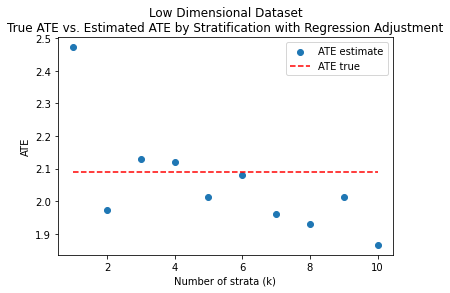

In [44]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title(dataset_name + "\nTrue ATE vs. Estimated ATE by Stratification with Regression Adjustment")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

In [ ]:
def Calculate_ATE_StratRegrAdjusted_with_X_CV(data_for_ATE:pd.DataFrame, k:int):
    return None

## conclusion

In [ ]:
######put the final result here

## references


1. Evaluating Online Ad Campaigns in a Pipeline: Causal Models At Scale - defines the general framework of causal inference in the marketing context. Specifically, we want to evaluate three methods as mentioned in sections 4 and 5 (Propensity Matching, Inverse Propensity Weighting, and Doubly Robust Estimation). Also Section 7 discusses model selection and validation (evaluation).

2. Propensity score methods for bias reduction in the comparison of a treatment to a non-randomized control group - discusses stratification and regression (covariance) adjustment combined with propensity scores (see sections STRATIFICATION and REGRESSION (COVARIANCE) ADJUSTMENT).

3. Estimation of Causal Effects using Propensity ScoreWeighting: An Application to Data on Right HeartCatheterization - discusses the weighted logistic regression model (see section 2).

4. An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies - discusses using propensity score as a covariate in the regression adjustment (see section Covariate Adjustment Using the Propensity Score).

5. Matching Methods for Causal Inference: A Review and a Look Forward - Section 3 introduces different matching methods for ATE and ATT (including full matching and inverse probability of treatment weighting). Section 5 talks about analysis after the matching.

6. Stratification and weighting via the propensity score in estimation of causal treatment effects: See Section 2 for stratification (or subclassification) using propensity score and doubly robust estimation, with the goal of estimating ATE.

7. Overcoming Class Imbalance using SMOTE Techniques, https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=SMOTE%20is%20an%20oversampling%20technique%20where%20the%20synthetic,interpolation%20between%20the%20positive%20instances%20that%20lie%20together.


8. Github Page of Applied Data Science https://github.com/TZstatsADS/ADS_Teaching/blob/master/Projects_StarterCodes/Project4-CausalInference/doc/project4_desc.md
